# Modelagem
## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import json
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
RANDOM_STATE = 42

## Funções auxiliares

In [3]:
def load_dataset(root="data", drop_columns=None):
    df_train = pd.read_csv(os.path.join(root, "train.csv"))
    df_test = pd.read_csv(os.path.join(root, "test.csv"))

    # remoção de colunas indesejadas
    if drop_columns is not None:
        df_train = df_train.drop(columns=drop_columns)
        df_test = df_test.drop(columns=drop_columns)
    
    return df_train, df_test


class DataImputer():
    def __init__(self):
        self.feat_values = {}
        
    def fit(self, df: pd.DataFrame):
        for col in df.columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                self.feat_values[col] = df[col].median()
            else:
                self.feat_values[col] = df[col].mode()[0]

        return self

    def transform(self, df: pd.DataFrame):
        df_copy = df.copy()
        for col, val in self.feat_values.items():
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].fillna(val)

        return df_copy

    def fit_transform(self, df: pd.DataFrame):
        self.fit(df)
        return self.transform(df)


class FeatureMapping():
    def __init__(self, mapping_path: str):
        with open(mapping_path, "rb") as fp:
            self._mapping = json.load(fp)
            
    def transform(self, df: pd.DataFrame):
        df_copy = df.copy()
        for col in self._mapping:
            if col not in df_copy:
                continue
            df_copy[col] = df_copy[col].map(self._mapping[col]).fillna(-1).astype(int)

        return df_copy


def filter_outlier(X, y, remove_percentage=0.05, random_state=None):
    if remove_percentage <= 0:
        return X, y

    model = IsolationForest(contamination=remove_percentage, random_state=random_state)
    yhat = model.fit_predict(X)

    return X.loc[yhat != -1], y.loc[yhat != -1]


def model_train_and_eval(
    df,
    n_splits=10,
    n_estimators=100,
    target_column="SalePrice",
    handle_null=False,
    outliers_filter_perc=0.0,
    debug=True,
    objective="reg:absoluteerror"
):
    df_train = df.copy()
    kf = KFold(n_splits=n_splits)
    featmap = FeatureMapping("model/mapping.json")
    df_train = featmap.transform(df_train)

    imputer = DataImputer()
    results = {"mse": [], "mae": []}

    X, y = df_train.drop(target_column, axis=1), df_train[target_column]

    for seed, (i, j) in tqdm(enumerate(kf.split(X, y)), disable=not debug):
        # Train / Test Split
        X_train, y_train, X_val, y_val = X.loc[i], y.loc[i], X.loc[j], y.loc[j]

        if outliers_filter_perc > 0:
            # Filtro de outliers
            X_train, y_train = filter_outlier(X_train, y_train, outliers_filter_perc, random_state=seed)
        
        if handle_null:
            # Tratamento de nulos
            X_train = imputer.fit_transform(X_train)
            X_val = imputer.transform(X_val)
        
        # Modelo
        model = xgb.XGBRegressor(objective=objective, n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        results["mse"].append(metrics.mean_squared_error(y_val.values, y_pred))
        results["mae"].append(metrics.mean_absolute_error(y_val.values, y_pred))

    if debug:
        print("Average MSE: %.2f +- %.2f" % (np.mean(results["mse"]), np.std(results["mse"])))
        print("Average MAE: %.2f +- %.2f" % (np.mean(results["mae"]), np.std(results["mae"])))

    return model, results

## Avaliando o modelo com todas as features

#### Avaliando modelo apenas com Feature Mapping

In [4]:
df_train, _ = load_dataset(drop_columns=["Order", "PID", "Misc Feature"])
model_train_and_eval(df_train, handle_null=False, outliers_filter_perc=0.0, n_splits=5);

5it [00:02,  2.01it/s]

Average MSE: 750745497.60 +- 144233617.09
Average MAE: 16661.42 +- 716.88


#### Avaliando modelo com Feat. Map. + tratamento de nulos

In [5]:
df_train, _ = load_dataset(drop_columns=["Order", "PID", "Misc Feature"])
model_train_and_eval(df_train, handle_null=True, outliers_filter_perc=0.0, n_splits=5);

5it [00:01,  2.65it/s]

Average MSE: 733240844.80 +- 160016742.08
Average MAE: 16494.58 +- 544.82


#### Avaliando model com Feat. Map. e remoção 1% de outliers dos dados de treino

In [6]:
df_train, _ = load_dataset(drop_columns=["Order", "PID", "Misc Feature"])
model_train_and_eval(df_train, handle_null=True, outliers_filter_perc=0.01, n_splits=5);

5it [00:03,  1.65it/s]

Average MSE: 741434995.20 +- 171172319.61
Average MAE: 16382.16 +- 646.15


### Tuning

#### Comparando impacto do número de Estimators

In [7]:
for est in [10, 25, 50, 100, 200, 500]:
    print("-" * 50)
    print(f"Estimadores: {est}")
    model_train_and_eval(df_train, n_estimators=est, n_splits=5, handle_null=False, outliers_filter_perc=0.0)
    print("-" * 50 + "\n")

--------------------------------------------------
Estimadores: 10


5it [00:00, 10.87it/s]


Average MSE: 1118776755.20 +- 264196328.46
Average MAE: 19346.68 +- 1092.37
--------------------------------------------------

--------------------------------------------------
Estimadores: 25


5it [00:01,  3.40it/s]


Average MSE: 800632294.40 +- 185611950.05
Average MAE: 17068.72 +- 827.72
--------------------------------------------------

--------------------------------------------------
Estimadores: 50


5it [00:01,  4.05it/s]


Average MSE: 755619494.40 +- 150893933.90
Average MAE: 16730.17 +- 722.64
--------------------------------------------------

--------------------------------------------------
Estimadores: 100


5it [00:02,  2.26it/s]


Average MSE: 750745497.60 +- 144233617.09
Average MAE: 16661.42 +- 716.88
--------------------------------------------------

--------------------------------------------------
Estimadores: 200


5it [00:03,  1.39it/s]


Average MSE: 728630899.20 +- 129847447.42
Average MAE: 16518.47 +- 742.52
--------------------------------------------------

--------------------------------------------------
Estimadores: 500


5it [00:10,  2.13s/it]

Average MSE: 721109676.80 +- 137676195.47
Average MAE: 16385.60 +- 732.22
--------------------------------------------------



O cenário ideal seria realizar um gridsearch, variando parâmetros para um tuning ideal do modelo.

## Análise de importância das features

In [8]:
df_train, _ = load_dataset(drop_columns=["Order", "PID", "Misc Feature"])
featmap = FeatureMapping("model/mapping.json")
df_train = featmap.transform(df_train)

X, y = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Modelo
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

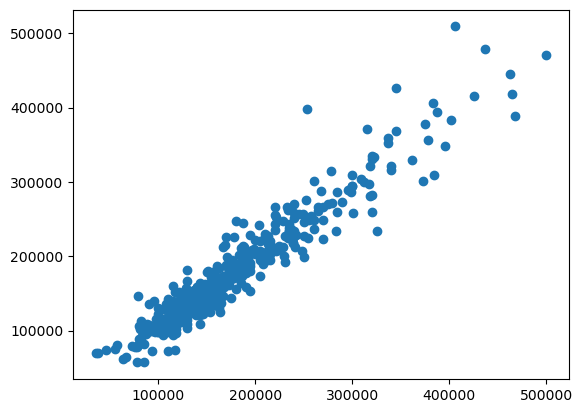

In [9]:
plt.scatter(y_val.values, y_pred)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

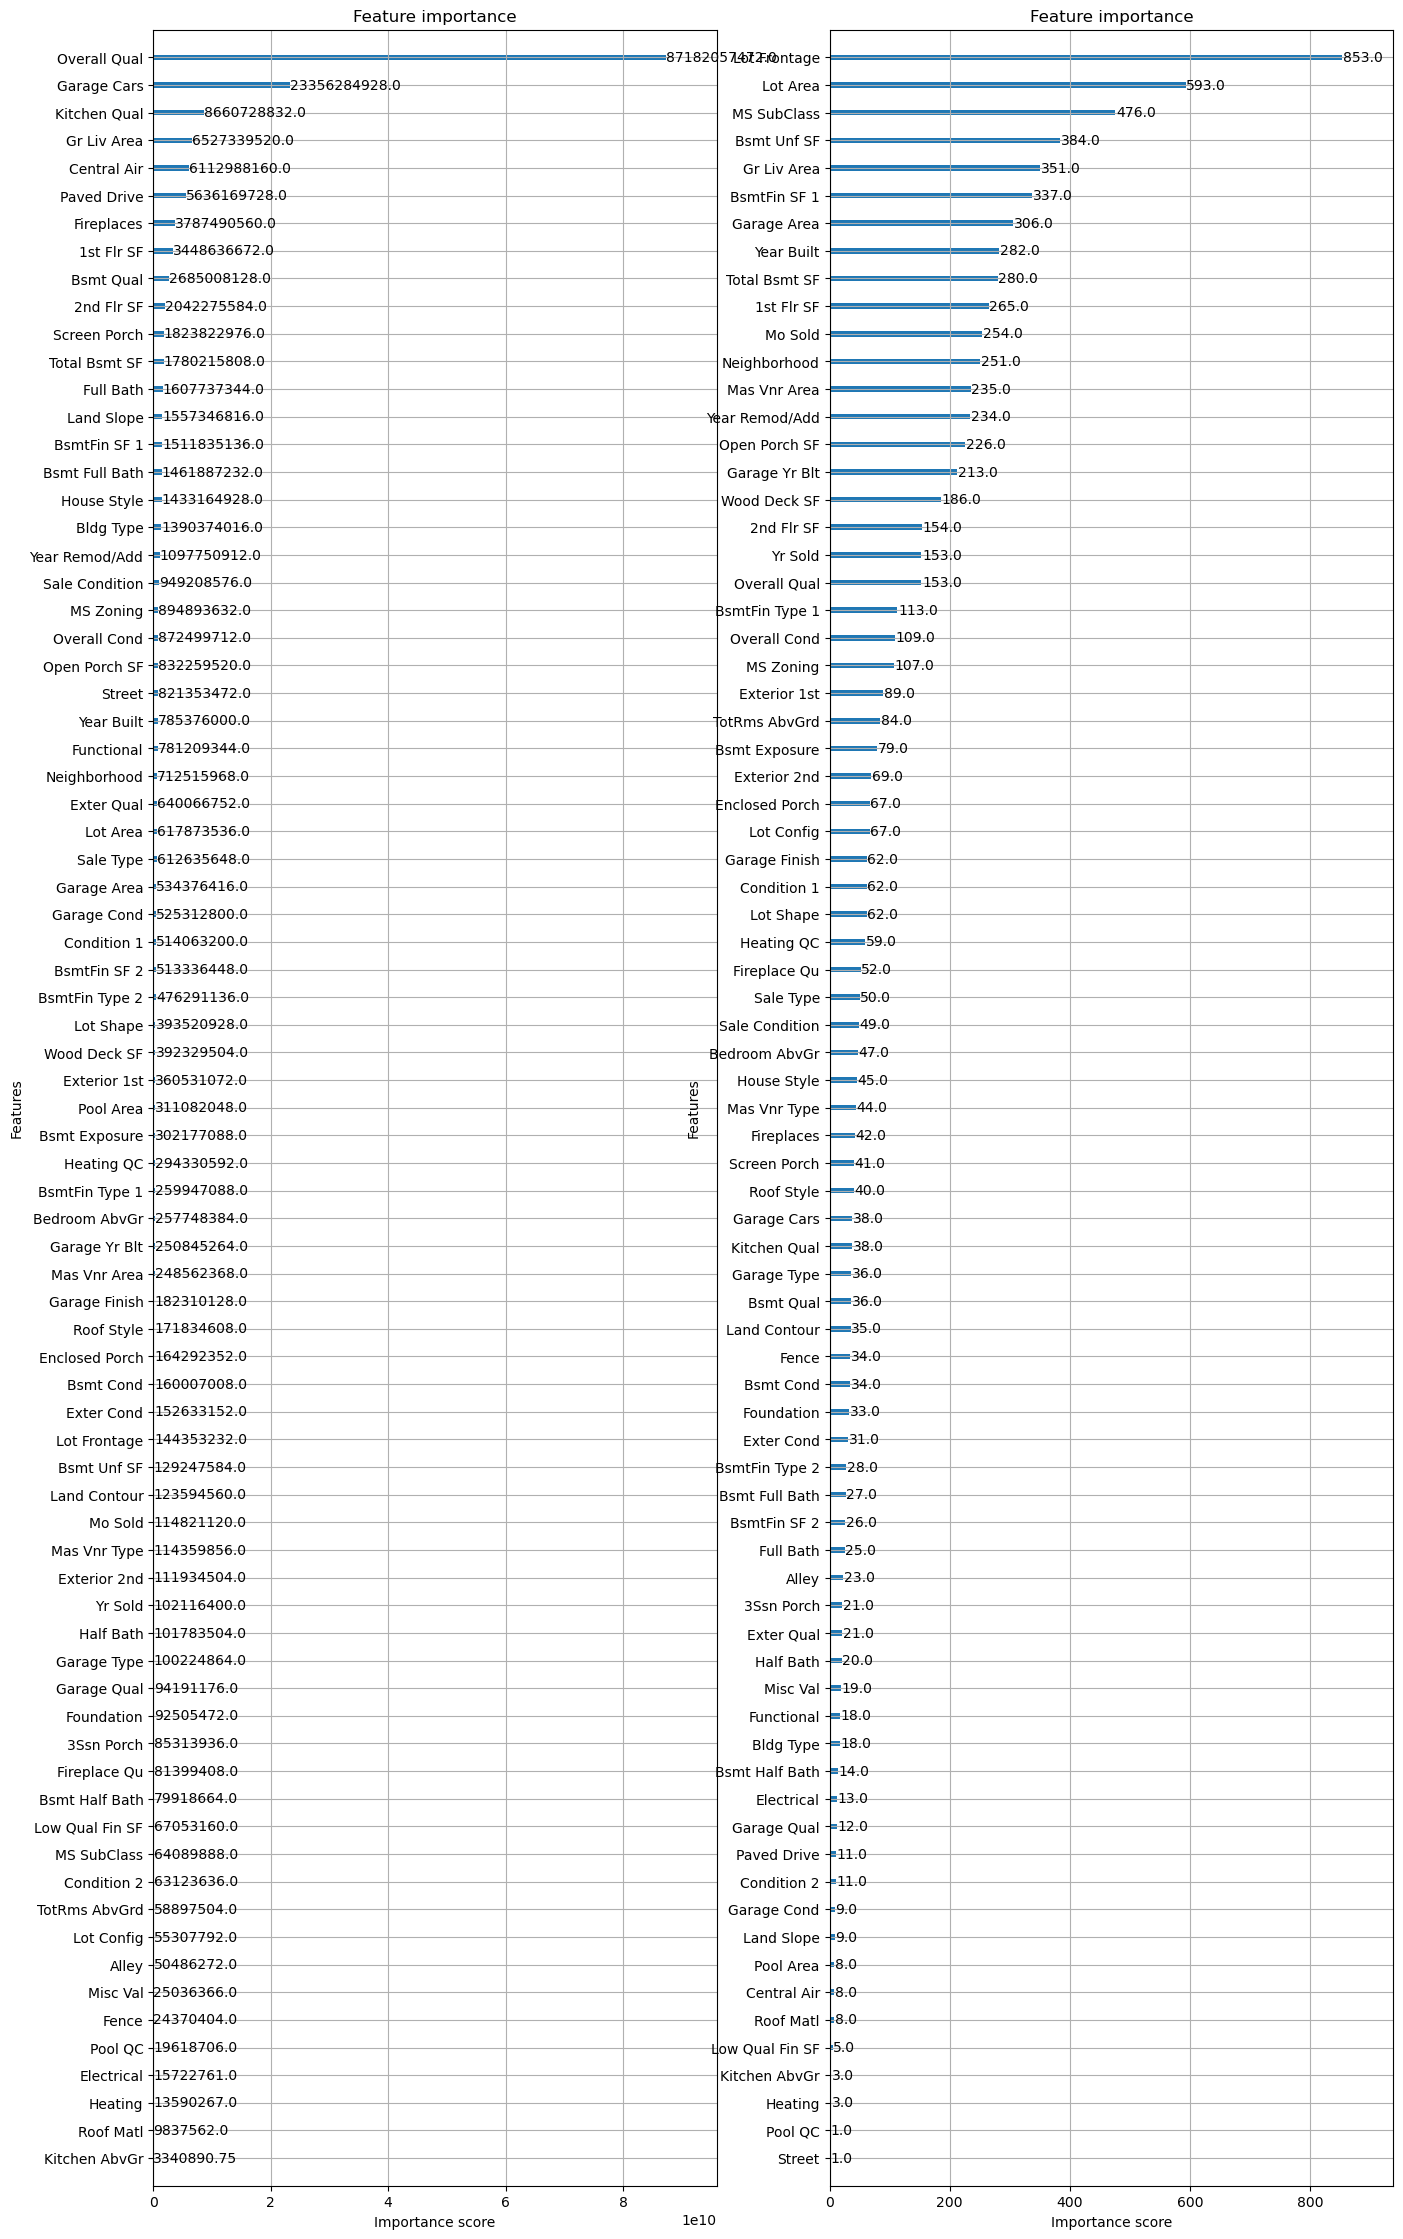

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 28))
xgb.plot_importance(model, importance_type='gain', ax=ax[0])
xgb.plot_importance(model, importance_type='weight', ax=ax[1])

Aqui novamente a feature "Overall Qual" se sobressai. No entanto todas as features parecem apresentar alguma contribuição.

## Seleção de features

Existem diferentes formas de selecionar as features pode ser por meio da matriz de correlações criadas no primeiro notebook. Pode ser usando o método RFE (Recursive Feature Elimination). Porém, aqui eu optei por treinar o modelo considerando de 2 até o máximo de features do dataset seguindo a ordem de importância das features calculadas pelo XGBoost.

In [11]:
mse = []
mae = []

importance = model.feature_importances_
idx = np.argsort(importance)[::-1]

df_train, _ = load_dataset(drop_columns=["Order", "PID", "Misc Feature"])
for N in tqdm(range(2, len(X_train.columns))):
    selected_features = X.columns[idx][:N]
    _, results = model_train_and_eval(df_train[list(selected_features) + ["SalePrice"]], n_estimators=50, n_splits=5, debug=False)
    
    mse.append(np.mean(results["mse"]))
    mae.append(np.mean(results["mae"]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [01:48<00:00,  1.43s/it]


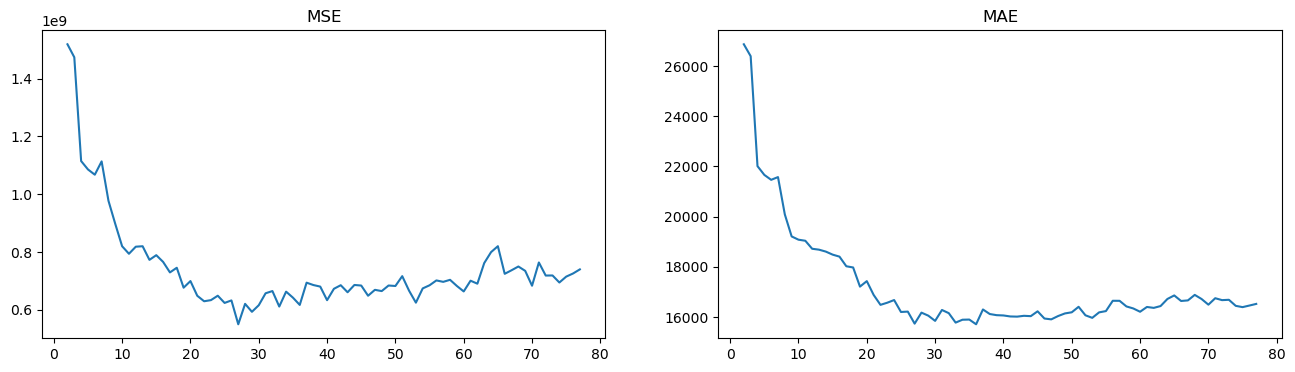

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(range(2, len(idx)), mse)
ax[0].title.set_text('MSE')

ax[1].plot(range(2, len(idx)), mae)
ax[1].title.set_text('MAE')
plt.show()

O ponto de menor erro apresentasse com um total de 61 features, no entanto o erro é relativamente ruidoso, logo esse pode não ser necessariamente o número ideal de features mas por simplicidade vamos seguir com essa quantidade.

In [22]:
N = 27
selected_features = X.columns[idx][:N]
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

model_train_and_eval(df_train, n_estimators=250, n_splits=5);
model_train_and_eval(df_train[list(selected_features) + ["SalePrice"]], n_estimators=250, n_splits=5);

5it [00:03,  1.28it/s]


Average MSE: 727587577.60 +- 131656046.59
Average MAE: 16486.32 +- 740.03


5it [00:02,  2.19it/s]

Average MSE: 532311142.40 +- 61451057.46
Average MAE: 15623.70 +- 803.96


**Comparativo entre os resultados**
- Modelo treinado com 78 features: MAE=16486
- Modelo treinado com 27 features: MAE=15623

Vemos que remover as features de menor importância trouxe ganho de performance.


In [23]:
# Salvar features para uso futuro
with open("model/features.json", "w") as fp:
    json.dump({"features": list(selected_features)}, fp)

## Construindo o modelo final

In [24]:
class SalePriceModel():
    def __init__(self, features: list, target: str, mapping):
        self._model = None
        self._features = features
        self._target = target
        self._mapping = mapping

    def train(self, df, **kwargs):
        # Prepare data
        X, y = df.drop(self._target, axis=1), df[self._target]
        X = self._mapping.transform(X)

        # Fit model
        self._model = xgb.XGBRegressor(objective="reg:absoluteerror", **kwargs)
        self._model.fit(X[self._features], y)
    
    def predict(self, X_test):
        X_test = self._mapping.transform(X_test)
        return self._model.predict(X_test[self._features])

In [25]:
from model import SalePriceModel, FeatureMapping

with open("model/features.json", "r") as fp:
    features = json.load(fp)["features"]

sp_model = SalePriceModel(
    features=features,
    target="SalePrice",
    mapping=FeatureMapping("model/mapping.json")
)

df_train, df_test = load_dataset(drop_columns=["Order", "PID", "Misc Feature"])

sp_model.train(df_train, n_estimators=250, random_state=RANDOM_STATE)

In [32]:
y_pred = sp_model.predict(df_test)

#### Salvando o modelo e os resultados

In [33]:
with open("model/model.pkl", "wb") as fp:
    pickle.dump(sp_model, fp)

## Testando a API

In [35]:
import requests
_, df_test = load_dataset()

data = df_test.replace({np.nan: None})
data = data.replace({np.nan: None}).to_dict(orient="records")
data = {"features": data}

response = requests.post("http://127.0.0.1:8000/predict", json=data)

df_test["SalePrice"] = response.json()["predictions"]
df_test.to_csv("data/predictions.csv")

print(response.json())

{'predictions': [181483, 102217, 191997, 136586, 116887, 170597, 137905, 147477, 99005, 333995, 243826, 230674, 83722, 136460, 116829, 158107, 148810, 193859, 127626, 144335, 197539, 130549, 203656, 214058, 203229, 322989, 328063, 213045, 196759, 216521, 196651, 88799, 211284, 95362, 116636, 71308, 195396, 334544, 184596, 242977, 341458, 204289, 244906, 194515, 101357, 339883, 191614, 142982, 180141, 125241, 161592, 140573, 131702, 177819, 210358, 194563, 212026, 138460, 235902, 151547, 55269, 203329, 84714, 362069, 257179, 135970, 126548, 207139, 161901, 171992, 175077, 193837, 300608, 94797, 139717, 407565, 165529, 231941, 154000, 184109, 160945, 134344, 116399, 174700, 302025, 158270, 108457, 134969, 197960, 384727, 198395, 91754, 139631, 65818, 217302, 163558, 59645, 225686, 207253, 252821, 120290, 277927, 388286, 335163, 267555, 161260, 307969, 203691, 194662, 97023, 252843, 131679, 130198, 97082, 207923, 123769, 230972, 334978, 209226, 169046, 115598, 124505, 121247, 137869, 1115